In [40]:
import numpy as np
import pandas as pd
import glob


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline


rc = {'axes.facecolor': '#E3DCD1',
      'font.family': 'Lucida Sans Unicode',
      'grid.linestyle': '-',
      'grid.linewidth': '0.75',
      'grid.color': '#ffffff',
      'mathtext.fontset': 'stixsans',
      'mathtext.sf': 'sans',
      'legend.frameon': True}
plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans')
sns.set_style('darkgrid', rc=rc)
sns.set_palette("colorblind", color_codes=True)
sns.set(rc=rc)


## Outline for notebook

In this notebook we'll consider cell volume as a function of copy number. Note that the values reported in Schmidt et al. 2015 were measured by flow cytometry and come from Volkmer, B. & Heinemann, M. 2011. In discussions with RP and Ron Milo, there are potentially issues with those values. In more recent work using super-resolution microscopy volumes were measured somewhat more direction (also from Heinemann; Radziikoski et al. 2017). From Suckjoon Jun's lab, there are some additional cell volumes reported ( Taheri-Araghi, ..., Suckjoon Jun 2015).

## Load in data

In [41]:
# load in cell volumes reported
df_grow = pd.read_csv('../../../data/schmidt2016_growth_rates.csv')
df_grow = df_grow[df_grow.strain=='BW25113']

# vol_dict = pd.Series(df_grow['volume_fL'].values,index=df_grow['condition'].values).to_dict()

In [100]:
# load in Schmidt data
combined_df = pd.read_csv('../../../data/combined_copynumbers_Schmidt_Li_Tanguichi.csv')
combined_df = combined_df[combined_df.dataset == 'Schmidt']
combined_df = combined_df.replace({'Glucose': 'glucose',
 'LB': 'lb_miller',
 'Glycerol + AA': 'glycerol_pAA',
 'Acetate': 'acetate',
 'Fumarate': 'fumarate',
 'Glucosamine': 'glucosamine',
 'Glycerol': 'glycerol',
 'Pyruvate': 'pyruvate',
 'Chemostat µ=0.5': 'chemostat_u0.5',
 'Chemostat µ=0.35': 'chemostat_u0.35',
 'Chemostat µ=0.20': 'chemostat_u0.2',
 'Chemostat µ=0.12': 'chemostat_u0.12',
 'stationary_1day': 'stationary_1day',
 'stationary_3day': 'stationary_3day',
 'Osmotic-stress glucose': 'osmotic_stress_glucose',
 '42°C glucose': '42C',
 'pH6 glucose': 'pH6',
 'Xylose': 'xylose',
 'Mannose': 'mannose',
 'Galactose': 'galactose',
 'Succinate': 'succinate',
 'Fructose': 'fructose'})
combined_df.head()

,Unnamed: 0,Annotated functional COG class,Annotated functional COG group (description),Annotated functional COG groups (letter),Gene,condition,copy_number,copy_number_stdev,dataset,growth_rate,type
0,0,INFORMATION STORAGE AND PROCESSING,"Translation, ribosomal structure and biogenesis",J,rplA,glucose,28502.0,4514.7168,Schmidt,0.58,ribosomal
1,1,INFORMATION STORAGE AND PROCESSING,"Translation, ribosomal structure and biogenesis",J,rplA,lb_miller,76877.0,1614.4170,Schmidt,1.90,ribosomal
2,2,INFORMATION STORAGE AND PROCESSING,"Translation, ribosomal structure and biogenesis",J,rplA,glycerol_pAA,47366.0,587.3384,Schmidt,1.27,ribosomal
3,3,INFORMATION STORAGE AND PROCESSING,"Translation, ribosomal structure and biogenesis",J,rplA,acetate,11672.0,466.8800,Schmidt,0.30,ribosomal
4,4,INFORMATION STORAGE AND PROCESSING,"Translation, ribosomal structure and biogenesis",J,rplA,fumarate,17445.0,439.6140,Schmidt,0.42,ribosomal


In [102]:
for gene,data in combined_df.groupby(['Gene', 'condition']):
        data_list = {'Annotated functional COG class' : data['Annotated functional COG class'].values[0],
               'Annotated functional COG group (description)' : data['Annotated functional COG group (description)'].values[0],
                'Annotated functional COG groups (letter)' : data['Annotated functional COG groups (letter)'].values[0],
                'Gene' : data.Gene.values[0],
                'condition' :  data.condition.values[0],
                'copy_number' : data.copy_number.values[0],
                'copy_number_stdev' : data.copy_number_stdev.values[0],
                'dataset' : data.dataset.values[0],
                'type' : data.type.values[0],
                    'volume_fL' : df_grow[df_grow.condition==gene[1]].volume_fL.values[0]}
        combined_df = combined_df.append(data_list, ignore_index=True)

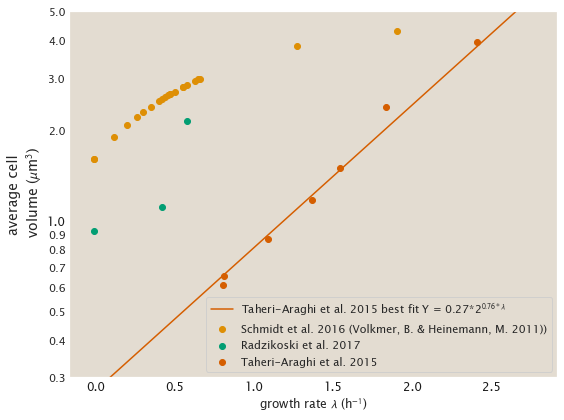

In [151]:
# set color for each dataset
pal = sns.color_palette(palette='colorblind', n_colors=8)
colorlist = pal.as_hex()
datasets_arr = np.append(combined_df.dataset.unique(), 
            ['Schmidt', 'Radzikoski', 'Taheri-Araghi'])
color_dict = dict(zip(datasets_arr, colorlist))

fig, ax = plt.subplots(1,1,figsize=(8,6))


###################
# Schmidt et al. 2015
combined_df = combined_df.sort_values('growth_rate', ascending=False)
df_group = combined_df.groupby('condition', sort = False)

for cond, data in df_group:

    ax.scatter(data.growth_rate.unique()[0], data['volume_fL'].unique()[1],
               label ='Schmidt et al. 2016 (Volkmer, B. & Heinemann, M. 2011))',
              color = color_dict['Schmidt'])
    ax.set_ylabel('copy number of\nDNA-associated proteins', fontsize=14)

###################
# Radzikoski et al. 2017
vol_new = {'fumarate':1.11, 'glucose':2.15, 'stationary_1day':0.92}
for i, cond in enumerate(['fumarate','glucose','stationary_1day']):
    growthrate =  combined_df[combined_df.condition==cond].growth_rate.unique()[0]  
    
    ax.scatter(growthrate, vol_new[cond], color = color_dict['Radzikoski'],
                label='Radzikoski et al. 2017' )

###################
# Taheri-Araghi et al. 2015
# volumes from Taheri-Araghi, ..., Suckjoon Jun 2015
x_data = np.array([1.16, 1.17, 1.57, 1.97, 2.23, 2.64, 3.47])
y_data = np.array([0.61, 0.65, 0.87, 1.17, 1.50, 2.39, 3.95])
ax.scatter(x_data*np.log(2),y_data, label = 'Taheri-Araghi et al. 2015', color = color_dict['Taheri-Araghi'])

x = np.linspace(combined_df.growth_rate.min(), 4, 100)
y = 0.27*2**(1.10*x)
ax.plot(x*np.log(2),y, label = 'Taheri-Araghi et al. 2015 best fit Y = 0.27*2$^{0.76*\lambda}$',
       color = color_dict['Taheri-Araghi'])



ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set_ylabel('average cell\n volume ($\mu$m$^3$)')
ax.set_xlabel('growth rate $\lambda$ (h$^{-1}$)')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(False)
plt.tick_params(which='both', width=1)
plt.tick_params(which='both', length=12, color='white')
# plt.tick_params(axis='y', which='minor', labelsize=14)
ax.get_yaxis().set_tick_params(which='both', direction='in') 
ax.get_xaxis().set_tick_params(which='both', direction='in') 
ax.tick_params(axis='both', colors='white', labelcolor='k')

ax.set_yscale('log')

# Put a legend to the right of the current axis
lgd = ax.legend( loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, ncol=1)

from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

ax.set_ylim(0.3,5)
plt.tight_layout()